# Light-cone coordinate conversion

In [1]:
import numpy as np
import tools21cm as t2c

The epoch of reionization and cosmic dawn is simulated in comoving distances (physical coordinates) where as the 21-cm signal will be observed in observational coordinates ($\theta_x, \theta_y, \nu$).

In this tutorial, we will map the light-cone between these two coordinate spaces.

### Plotting functions

In [2]:
import matplotlib.pyplot as plt

In [3]:
def plot_lc(lc, loc_axis, fov, xlabel='z', ylabel='L (cMpc)', fig=None, axs=None, title=None):
    data = {'lc': lc, 'z': loc_axis}
    xi = np.array([data['z'] for i in range(data['lc'].shape[1])])
    yi = np.array([np.linspace(0,fov,data['lc'].shape[1]) for i in range(xi.shape[1])]).T
    zj = (data['lc'][100,1:,1:]+data['lc'][100,1:,:-1]+data['lc'][100,:-1,1:]+data['lc'][100,:-1,:-1])/4

    if fig is None or axs is None:
        fig, axs = plt.subplots(1,1, figsize=(14, 5))
        if title is not None: axs.set_title(title, fontsize=18)
        im = axs.pcolor(xi, yi, zj, cmap='jet')
        axs.set_xlabel(xlabel, fontsize=18)
        axs.set_ylabel(ylabel, fontsize=18)
        if loc_axis[0]>loc_axis[-1]: axs.invert_xaxis()
        # axs.set_xticks(np.arange(6.5,13,1))
        # axs.set_yticks(np.arange(0,350,100))
        axs.tick_params(axis='both', which='major', labelsize=16)
        fig.subplots_adjust(bottom=0.11, right=0.91, top=0.95, left=0.06)
        cax = plt.axes([0.92, 0.15, 0.02, 0.75])
        fig.colorbar(im,cax=cax)
        # plt.tight_layout()
        # plt.show()


### Reading data
Here we read the light-cone data as a numpy array.

In [4]:
import pickle

In [5]:
box_len = 244/0.7 # Mpc

In [6]:
path_to_datafiles = '../../../../simulations/lightcones/'
filename = path_to_datafiles+'lightcone_data.pkl'
data_phy = pickle.load(open(filename,'rb'))
print(data_phy.keys())

dict_keys(['lc', 'z'])


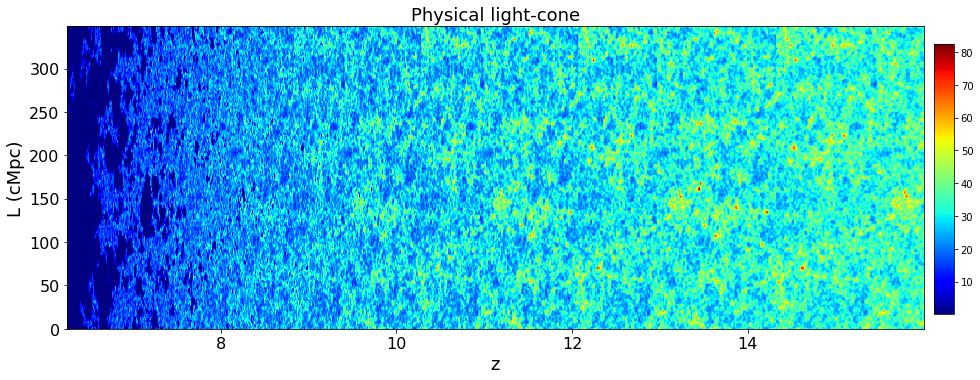

In [7]:
plot_lc(data_phy['lc'], data_phy['z'], fov=box_len, title='Physical light-cone', xlabel='z', ylabel='L (cMpc)')
plt.show()

## Converting physical to observational coordinates

Here we will use `physical_lightcone_to_observational` to map the light-cone from physical to observational coordinates. The maximum field of view in degrees that can be achieved corresponds to the data at the smallest redshift. The module will assume the light-cone to be periodic in the angular direction and pad data at higher redshifts to get constant field of view in degrees.

In [8]:
physical_lightcone = data_phy['lc']

Minimum angular size: 1.85 degrees
Maximum angular size: 2.31 degrees


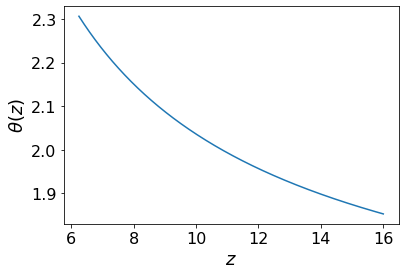

In [9]:
angular_size_deg = t2c.angular_size_comoving(box_len, data_phy['z'])
print('Minimum angular size: {:.2f} degrees'.format(angular_size_deg.min()))
print('Maximum angular size: {:.2f} degrees'.format(angular_size_deg.max()))

plt.plot(data_phy['z'], angular_size_deg)
plt.xlabel('$z$', fontsize=18)
plt.ylabel('$\\theta (z)$', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [10]:
physical_freq = t2c.z_to_nu(data_phy['z']) # redshift to frequencies in MHz

print('Minimum frequency gap in the physical light-cone data: {:.2f} MHz'.format(np.abs(np.gradient(physical_freq)).min()))
print('Maximum frequency gap in the physical light-cone data: {:.2f} MHz'.format(np.abs(np.gradient(physical_freq)).max()))


Minimum frequency gap in the physical light-cone data: 0.06 MHz
Maximum frequency gap in the physical light-cone data: 0.09 MHz


In [11]:
max_deg = 2.31
n_output_cell = 250

input_z_low   = data_phy['z'].min()
output_dnu    = 0.05                           #MHz
output_dtheta = (max_deg/(n_output_cell+1))*60 #arcmins
input_box_size_mpc = box_len

observational_lightcone, observational_freq = t2c.physical_lightcone_to_observational(physical_lightcone, 
                                                                                      input_z_low, 
                                                                                      output_dnu, 
                                                                                      output_dtheta, 
                                                                                      input_box_size_mpc=input_box_size_mpc)

100%|█████████████████████████████████| 2247/2247 [00:36<00:00, 61.54it/s]


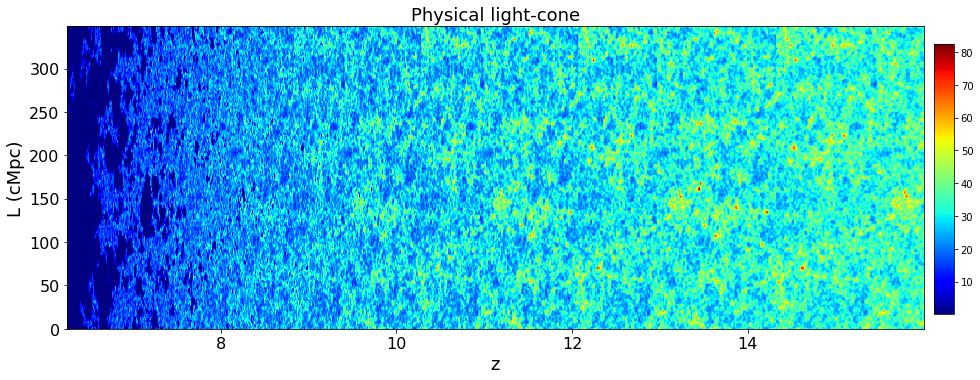

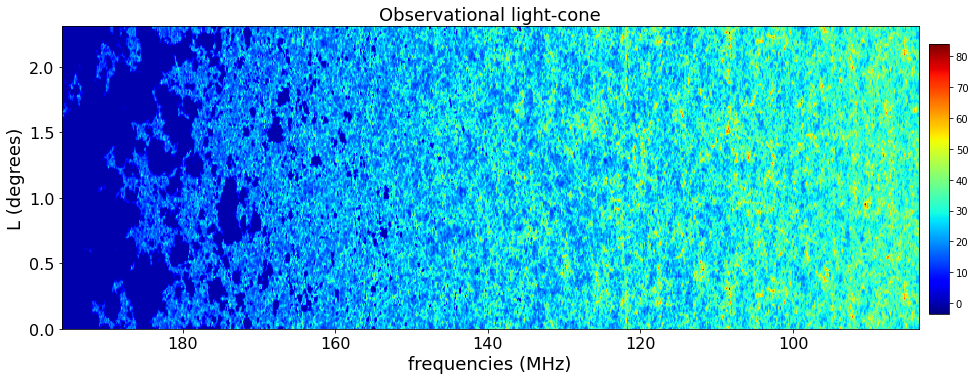

In [12]:
plot_lc(data_phy['lc'], data_phy['z'], fov=box_len, title='Physical light-cone', xlabel='z', ylabel='L (cMpc)')
plot_lc(observational_lightcone, observational_freq, fov=max_deg, title='Observational light-cone', xlabel='frequencies (MHz)', ylabel='L (degrees)')
plt.show()

### For larger observational light-cones

In order to construct an observational light-cone larger than the angular size of the smallest redshift, we can pad the physical light-cone before providing it to `physical_lightcone_to_observational` function. Tools21cm contains `padding_lightcone` for this purpose. This function keeps the original data at the center. Below we show an example where an observational light-cone is produced of twice the angular size.

In [13]:
padded_n_cells = int(physical_lightcone.shape[0]/2)
padded_lc = t2c.padding_lightcone(physical_lightcone, padded_n_cells)

100%|████████████████████████████████| 1523/1523 [00:09<00:00, 158.25it/s]


In [14]:
max_deg = 2.31*2
n_output_cell = 250*2

input_z_low   = data_phy['z'].min()
output_dnu    = 0.05                           #MHz
output_dtheta = (max_deg/(n_output_cell+1))*60 #arcmins
input_box_size_mpc = box_len*2

larger_observational_lightcone, larger_observational_freq = t2c.physical_lightcone_to_observational(padded_lc, 
                                                                                      input_z_low, 
                                                                                      output_dnu, 
                                                                                      output_dtheta, 
                                                                                      input_box_size_mpc=input_box_size_mpc)

100%|█████████████████████████████████| 2247/2247 [03:29<00:00, 10.72it/s]


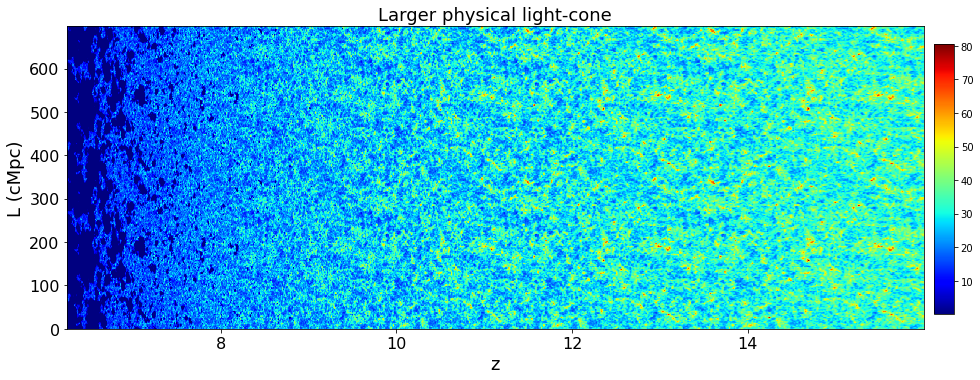

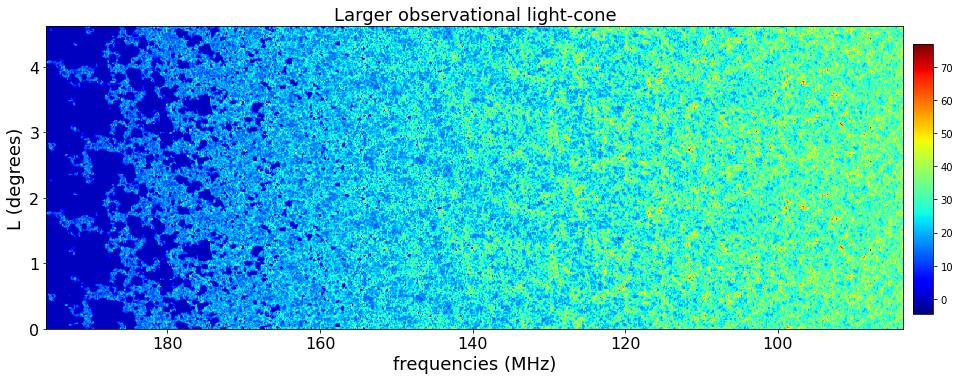

In [15]:
plot_lc(padded_lc, data_phy['z'], fov=box_len*2, title='Larger physical light-cone', xlabel='z', ylabel='L (cMpc)')
plot_lc(larger_observational_lightcone, larger_observational_freq, fov=max_deg, title='Larger observational light-cone', xlabel='frequencies (MHz)', ylabel='L (degrees)')
plt.show()

## Converting observational to physical coordinates

Here we will use `observational_lightcone_to_physical` to map the light-cone from observational to physical coordinates. The maximum field of view in degrees that can be achieved corresponds to the data at the smallest redshift. The module will assume the light-cone to be periodic in the angular direction and pad data at higher redshifts to get constant field of view in degrees.

In [16]:
max_deg       = 2.31 #degrees
n_output_cell = 250
input_dtheta  = (max_deg/(n_output_cell+1))*60 #arcmins

physical_lc_reconstructed, physical_redshifts_reconstructed, physical_cell_size_reconstructed = \
                                                    t2c.observational_lightcone_to_physical(observational_lightcone, 
                                                                                            observational_freq, 
                                                                                            input_dtheta)
physical_redshifts_reconstructed = (physical_redshifts_reconstructed[1:]+physical_redshifts_reconstructed[:-1])/2
box_len_reconstructed = physical_cell_size_reconstructed*physical_lc_reconstructed.shape[0]

100%|█████████████████████████████████| 2247/2247 [00:40<00:00, 55.49it/s]


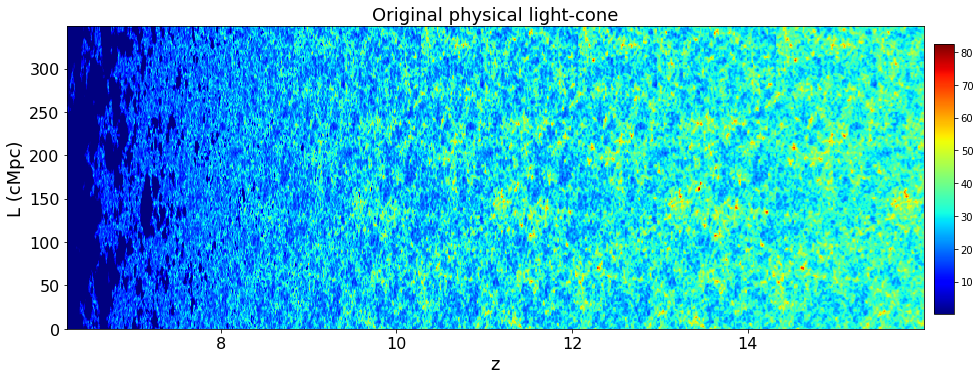

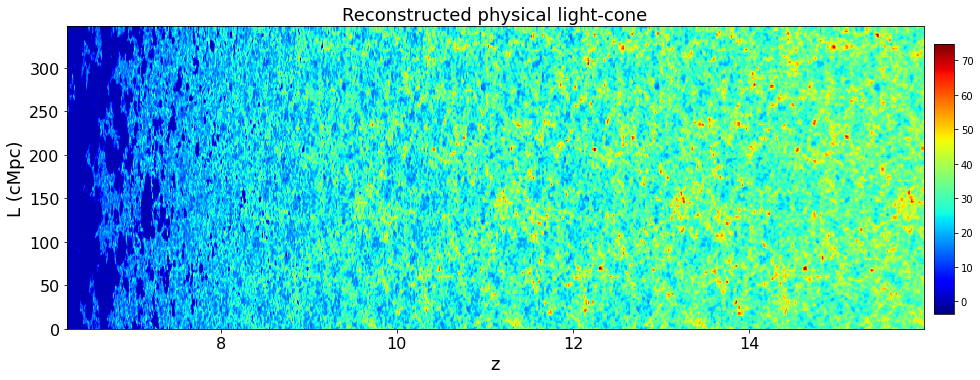

In [17]:
plot_lc(physical_lightcone, data_phy['z'], fov=box_len, title='Original physical light-cone', xlabel='z', ylabel='L (cMpc)')
plot_lc(physical_lc_reconstructed, physical_redshifts_reconstructed, fov=box_len_reconstructed, title='Reconstructed physical light-cone', xlabel='z', ylabel='L (cMpc)')
plt.show()

Note that the resolution (or box length) and redshifts of the reconstructed light-cone can sometimes be slightly changed compared to the original light-cone in physical coordinates. This change is because the interpolation and floating-point errors accumulated during the conversions. It will not have any significant impact on the analysis if reconstructed box length and redshifts are used for the reconstructed light-cone.